This notebook exists to systematize the testing of a new deployment to the MapMyCells webtool

In [1]:
import gzip
import json
import matplotlib.pyplot as plt
import numpy as np
import pathlib
import subprocess
import tempfile

In [2]:
from cell_type_mapper.utils.utils import (
    _clean_up
)

from cell_type_mapper.taxonomy.taxonomy_tree import (
    TaxonomyTree
)

from cell_type_mapper.evaluation.cdf_comparison import (
    mapping_cdf
)

from cell_type_mapper.evaluation.f1_scores import (
    avg_f1
)

In [3]:
home_dir = pathlib.Path('../')
results_dir = home_dir / 'results'
baseline_dir = home_dir / 'baseline'
base_scratch_dir = home_dir / 'scratch'

for d in (results_dir, baseline_dir, base_scratch_dir):
    assert d.is_dir()

# clean up scratch dirs from previous runs of this notebook
for p in base_scratch_dir.iterdir():
    if p.is_dir():
        _clean_up(p)

scratch_dir = pathlib.Path(
    tempfile.mkdtemp(
        dir=base_scratch_dir,
        prefix='scratch_'
    )
)


In [4]:
def extract_zip_package(src_path, scratch_dir, dir_prefix):
    """
    Extract a zip package to a temporary directory. Return the path to that directory.

    Parameters:
    -----------
    src_path:
        path to the .zip file being unpacked
    scratch_dir:
        directory in which to create the temporary directory
    dir_prefix:
        prefix to assign to the temporary directory's name

    Returns
    -------
    A dict whose values are the files we expect to be returned
    """
    src_path = pathlib.Path(src_path)
    dst_dir = pathlib.Path(
        tempfile.mkdtemp(
            dir=scratch_dir,
            prefix=f'{dir_prefix}_'
        )
    )

    process = subprocess.Popen(
        ["unzip", f"{src_path.resolve().absolute()}", "-d", f"{dst_dir.resolve().absolute()}"],
        stdout=subprocess.DEVNULL
    )
    process.wait()

    dst_files = [
        p for p in dst_dir.iterdir()
    ]

    output_package = dict()
    for file_path in dst_files:
        if file_path.name.startswith('validation_log'):
            output_package['validation_log'] = file_path
        elif file_path.name.endswith('summary_metadata.json'):
            output_package['summary_metadata'] = file_path
        elif file_path.name.endswith('csv'):
            output_package['csv'] = file_path
        elif file_path.name.endswith('.json'):
            output_package['json'] = file_path
        else:
            raise RuntimeError(
                f"Unsure where to put file {file_path}"
            )
    
    return output_package

In [5]:
def plot_performance(package_list, ground_truth, fontsize=15):
    json_file_path = package_list[0]['json']
    with open(json_file_path, 'rb') as src:
        taxonomy_tree = TaxonomyTree(data=json.load(src)['taxonomy_tree'])

    n_rows = 2
    n_cols = len(taxonomy_tree.hierarchy)

    npix = 10
    fig = plt.figure(figsize=(n_cols*npix, n_rows*npix))
    axis_lookup = {'f1': dict(), 'cdf': dict()}
    ct = 1
    for level in taxonomy_tree.hierarchy:
        axis = fig.add_subplot(n_rows, n_cols, ct)
        axis.set_title(level, fontsize=fontsize)
        axis.set_xlabel('probablity', fontsize=fontsize)
        axis.set_ylabel('F1', fontsize=fontsize)
        axis_lookup['f1'][level] = axis
        axis.set_xlim((0, 1.05))
        axis.set_ylim((0, 1.05))
        ct += 1

    for level in taxonomy_tree.hierarchy:
        axis = fig.add_subplot(n_rows, n_cols, ct)
        axis.set_title(level, fontsize=fontsize)
        axis.set_xlabel('probablity', fontsize=fontsize)
        axis.set_ylabel('CDF', fontsize=fontsize)
        axis_lookup['cdf'][level] = axis
        ct += 1

    for level in taxonomy_tree.hierarchy:
        for k in ('f1', 'cdf'):
            axis = axis_lookup[k][level]
            axis.tick_params(
                axis='both',
                which='both',
                labelsize=fontsize
            )
    
    color_list = ['blue', 'orange', 'magenta', 'cyan', 'green']

    for output_package, color in zip(package_list, color_list):
        plot_performance_one_dir(
            output_package=output_package,
            axis_lookup=axis_lookup,
            ground_truth=ground_truth,
            color=color
        )

    axis_lookup['f1'][taxonomy_tree.hierarchy[0]].legend(loc=0, fontsize=fontsize)


def plot_performance_one_dir(output_package, axis_lookup, ground_truth, color):
    """
    Parameters:
    -----------
    output_package:
        dict containing files produced by MapMyCells
    axis_lookup:
        dict keyed on ['f1', 'cdf'] and then level indicating the axes in which to plot
    ground_truth:
        the dict defining the ground truth cell type assignments for the cells in the dataset

    Returns
    -------
    None
        results are plotted in the relevant axes
    """
    json_file_path = output_package['json']
    with open(json_file_path, 'rb') as src:
        json_data = json.load(src)
    taxonomy_tree = TaxonomyTree(data=json_data['taxonomy_tree'])

    probability_cut_list = [ii*0.1 for ii in range(10)]
    f1_lookup = avg_f1(
        mapping=json_data['results'],
        truth=ground_truth,
        taxonomy_tree=taxonomy_tree,
        probability_cut_list=probability_cut_list)

    cdf_lookup = mapping_cdf(
        mapping=json_data['results'],
        truth=ground_truth,
        taxonomy_tree=taxonomy_tree,
        bin_resolution=0.05
    )
    
    json_name = json_file_path.name.replace('.json','')
    json_params = json_name.split('_')
    timestamp = json_params[-1]

    factor = json_data['config']['type_assignment']['bootstrap_factor']
    label = f'{timestamp}; bootstrapping_factor: {factor:.2f}'

    for level in taxonomy_tree.hierarchy:
        axis = axis_lookup['f1'][level]
        f1_values = [
            f1_lookup[level]['probability'][f'{c:.2f}']['macro']
            for c in probability_cut_list
        ]
        axis.plot(
            probability_cut_list,
            f1_values,
            color=color,
            label=label)

        axis = axis_lookup['cdf'][level]
        axis.plot(
            cdf_lookup[level]['bins'],
            cdf_lookup[level]['actual'],
            color=color,
            linestyle='-',
            label=label)
        
        axis.plot(
            cdf_lookup[level]['bins'],
            cdf_lookup[level]['expected'],
            color=color,
            linestyle='--')

# Mouse ground truth test

Test mapping of a Whole Mouse dataset for which ground truth is known (because it has been drawn from the Yao et al. single cell sequencing data)

In [6]:
with gzip.open(baseline_dir / 'mouse_truth.json.gz', 'rb') as src:
    mouse_truth = json.load(src)

In [7]:
mouse_zip_path_to_package = dict()

In [8]:
result_candidates = [str(p.resolve().absolute()) for p in results_dir.rglob('*mouse_test_merfish_gene_symbols*zip')]
result_candidates.sort()

for src_path in result_candidates:
    this_package = extract_zip_package(
        src_path=src_path,
        scratch_dir=scratch_dir,
        dir_prefix='mouse_ground_truth')
    mouse_zip_path_to_package[src_path] = this_package


/Users/scott.daniel/KnowledgeBase/knowledge_graph_prototypes/src/cell_type_mapper/taxonomy/utils.py:245: UserWarning: This taxonomy has no mapping from leaf_node -> rows in the cell by gene matrix
  warnings.warn("This taxonomy has no mapping from leaf_node -> rows "


CPU times: user 1min 49s, sys: 4.53 s, total: 1min 53s
Wall time: 1min 53s


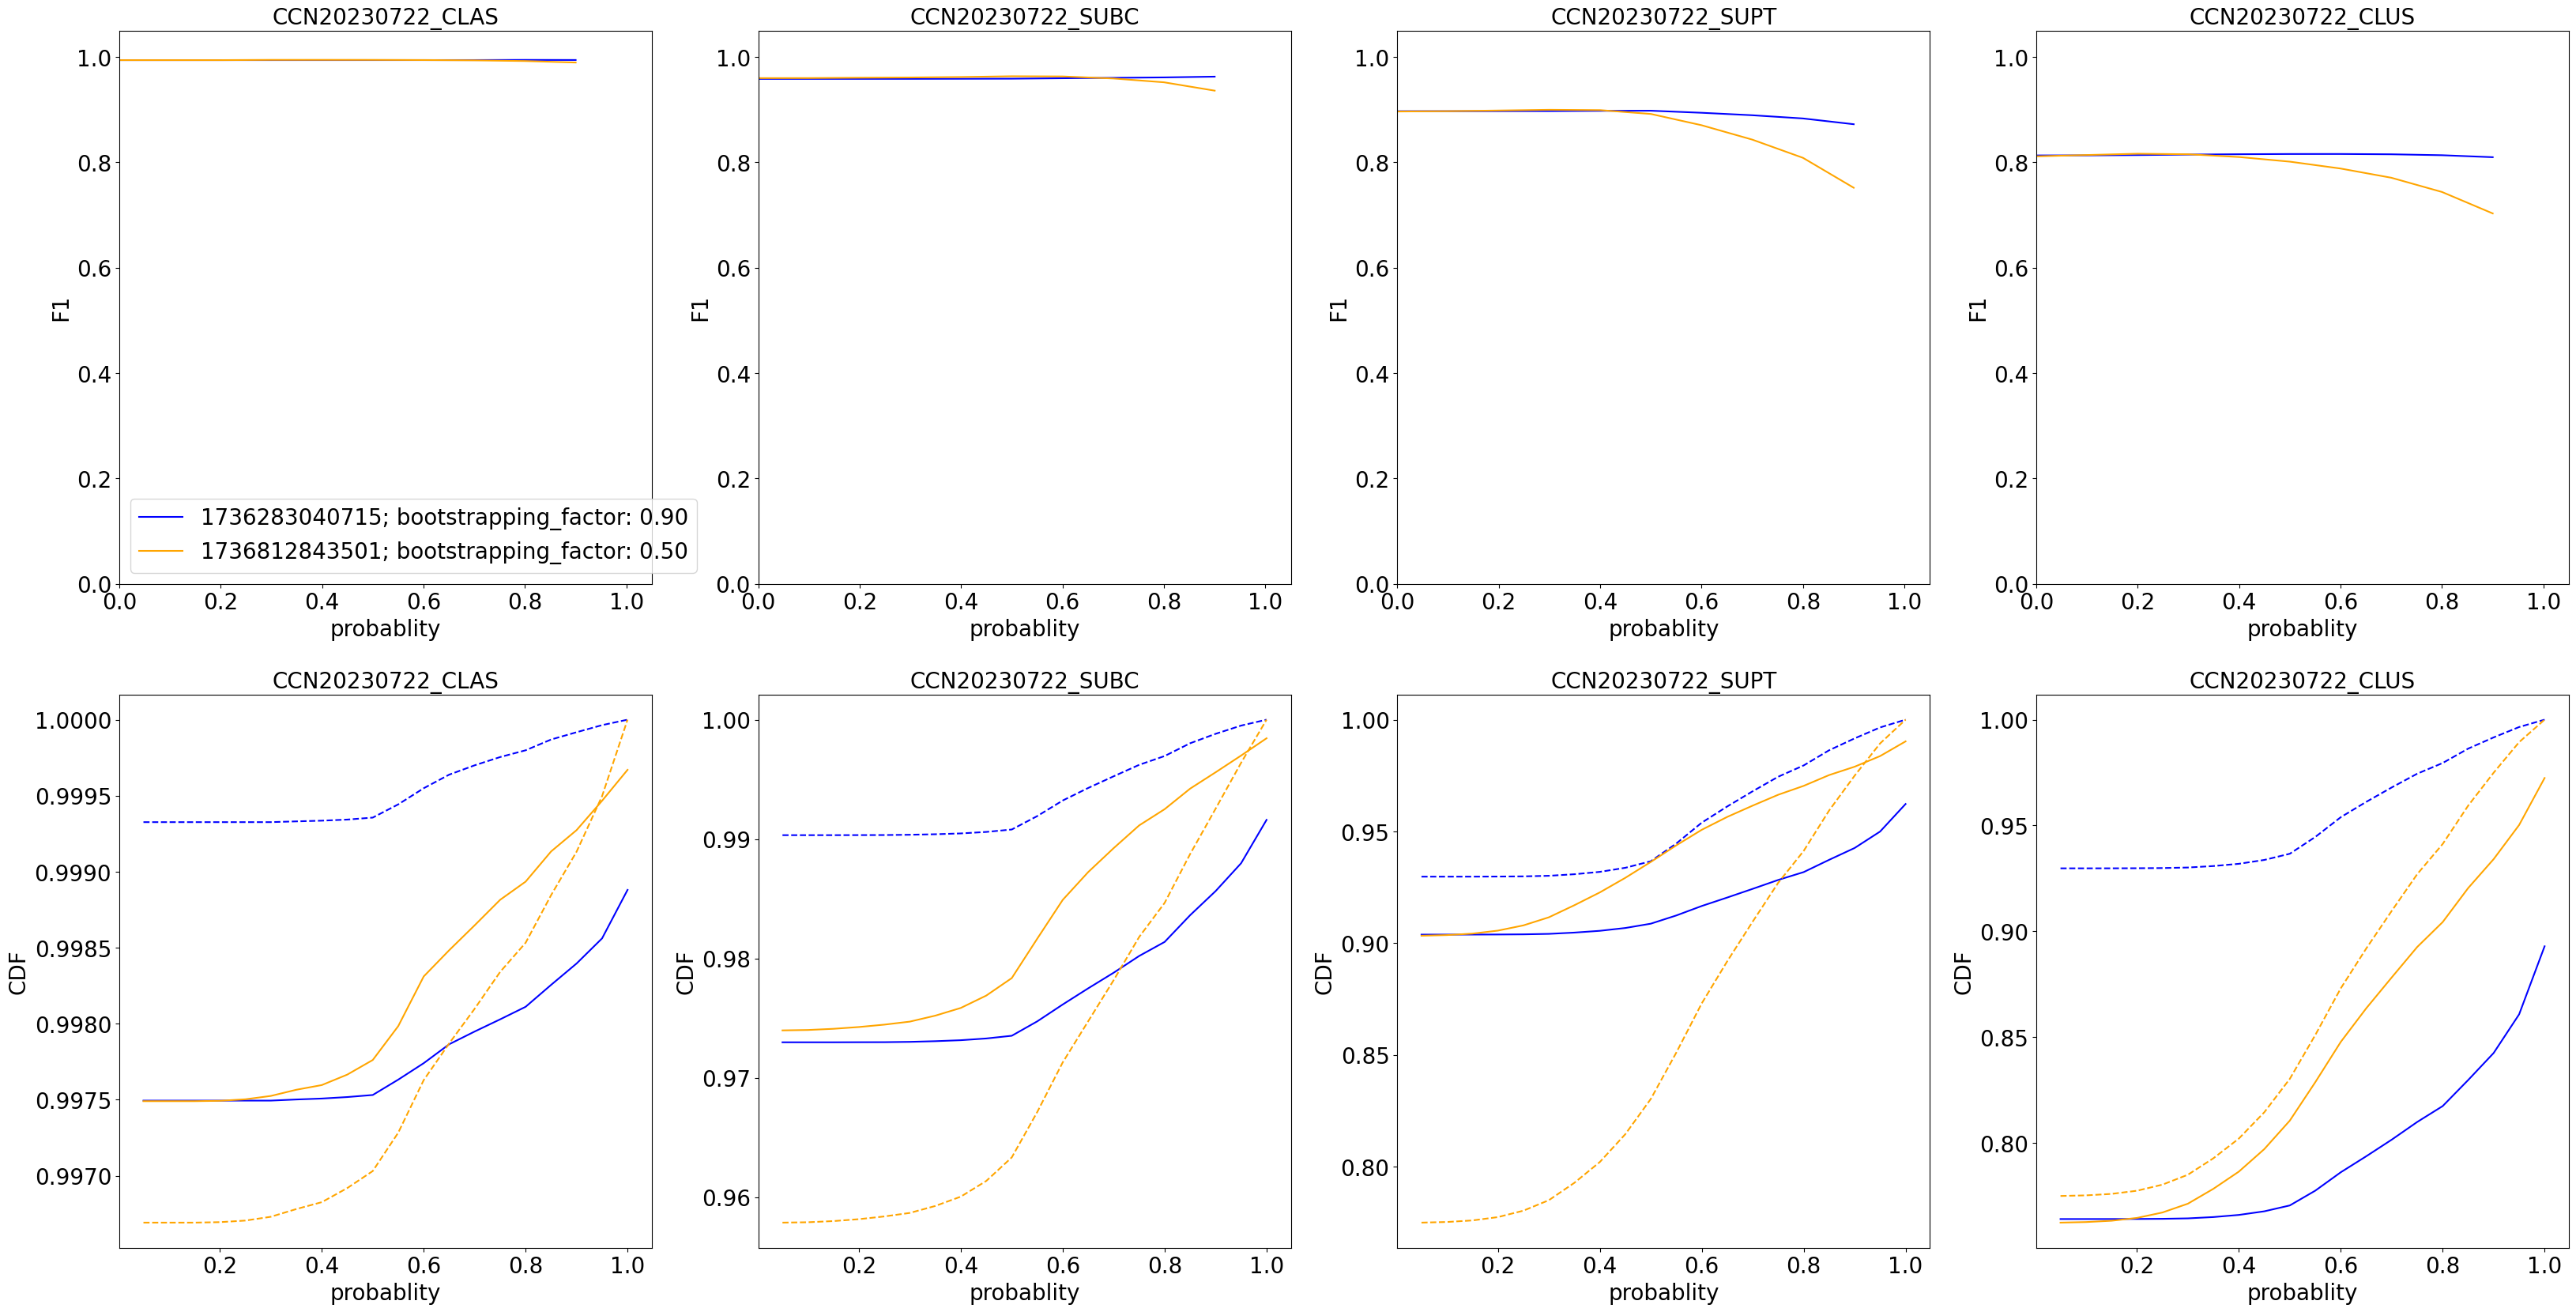

In [9]:
%%time
plot_performance(package_list=list(mouse_zip_path_to_package.values()), ground_truth=mouse_truth, fontsize=20)

# SEA-AD ground truth test

In [10]:
with gzip.open(baseline_dir / 'sea_ad_test_truth.json.gz', 'rb') as src:
    seaad_truth = json.load(src)

In [11]:
seaad_zip_path_to_package = dict()

In [12]:
result_candidates = [str(p.resolve().absolute()) for p in results_dir.rglob('*sea_ad_test_data_merfish_genes*zip')]
result_candidates.sort()

for src_path in result_candidates:
    this_package = extract_zip_package(
        src_path=src_path,
        scratch_dir=scratch_dir,
        dir_prefix='seaad_ground_truth')
    seaad_zip_path_to_package[src_path] = this_package

/Users/scott.daniel/KnowledgeBase/knowledge_graph_prototypes/src/cell_type_mapper/taxonomy/utils.py:245: UserWarning: This taxonomy has no mapping from leaf_node -> rows in the cell by gene matrix
  warnings.warn("This taxonomy has no mapping from leaf_node -> rows "


CPU times: user 30.6 s, sys: 1.31 s, total: 31.9 s
Wall time: 31.9 s


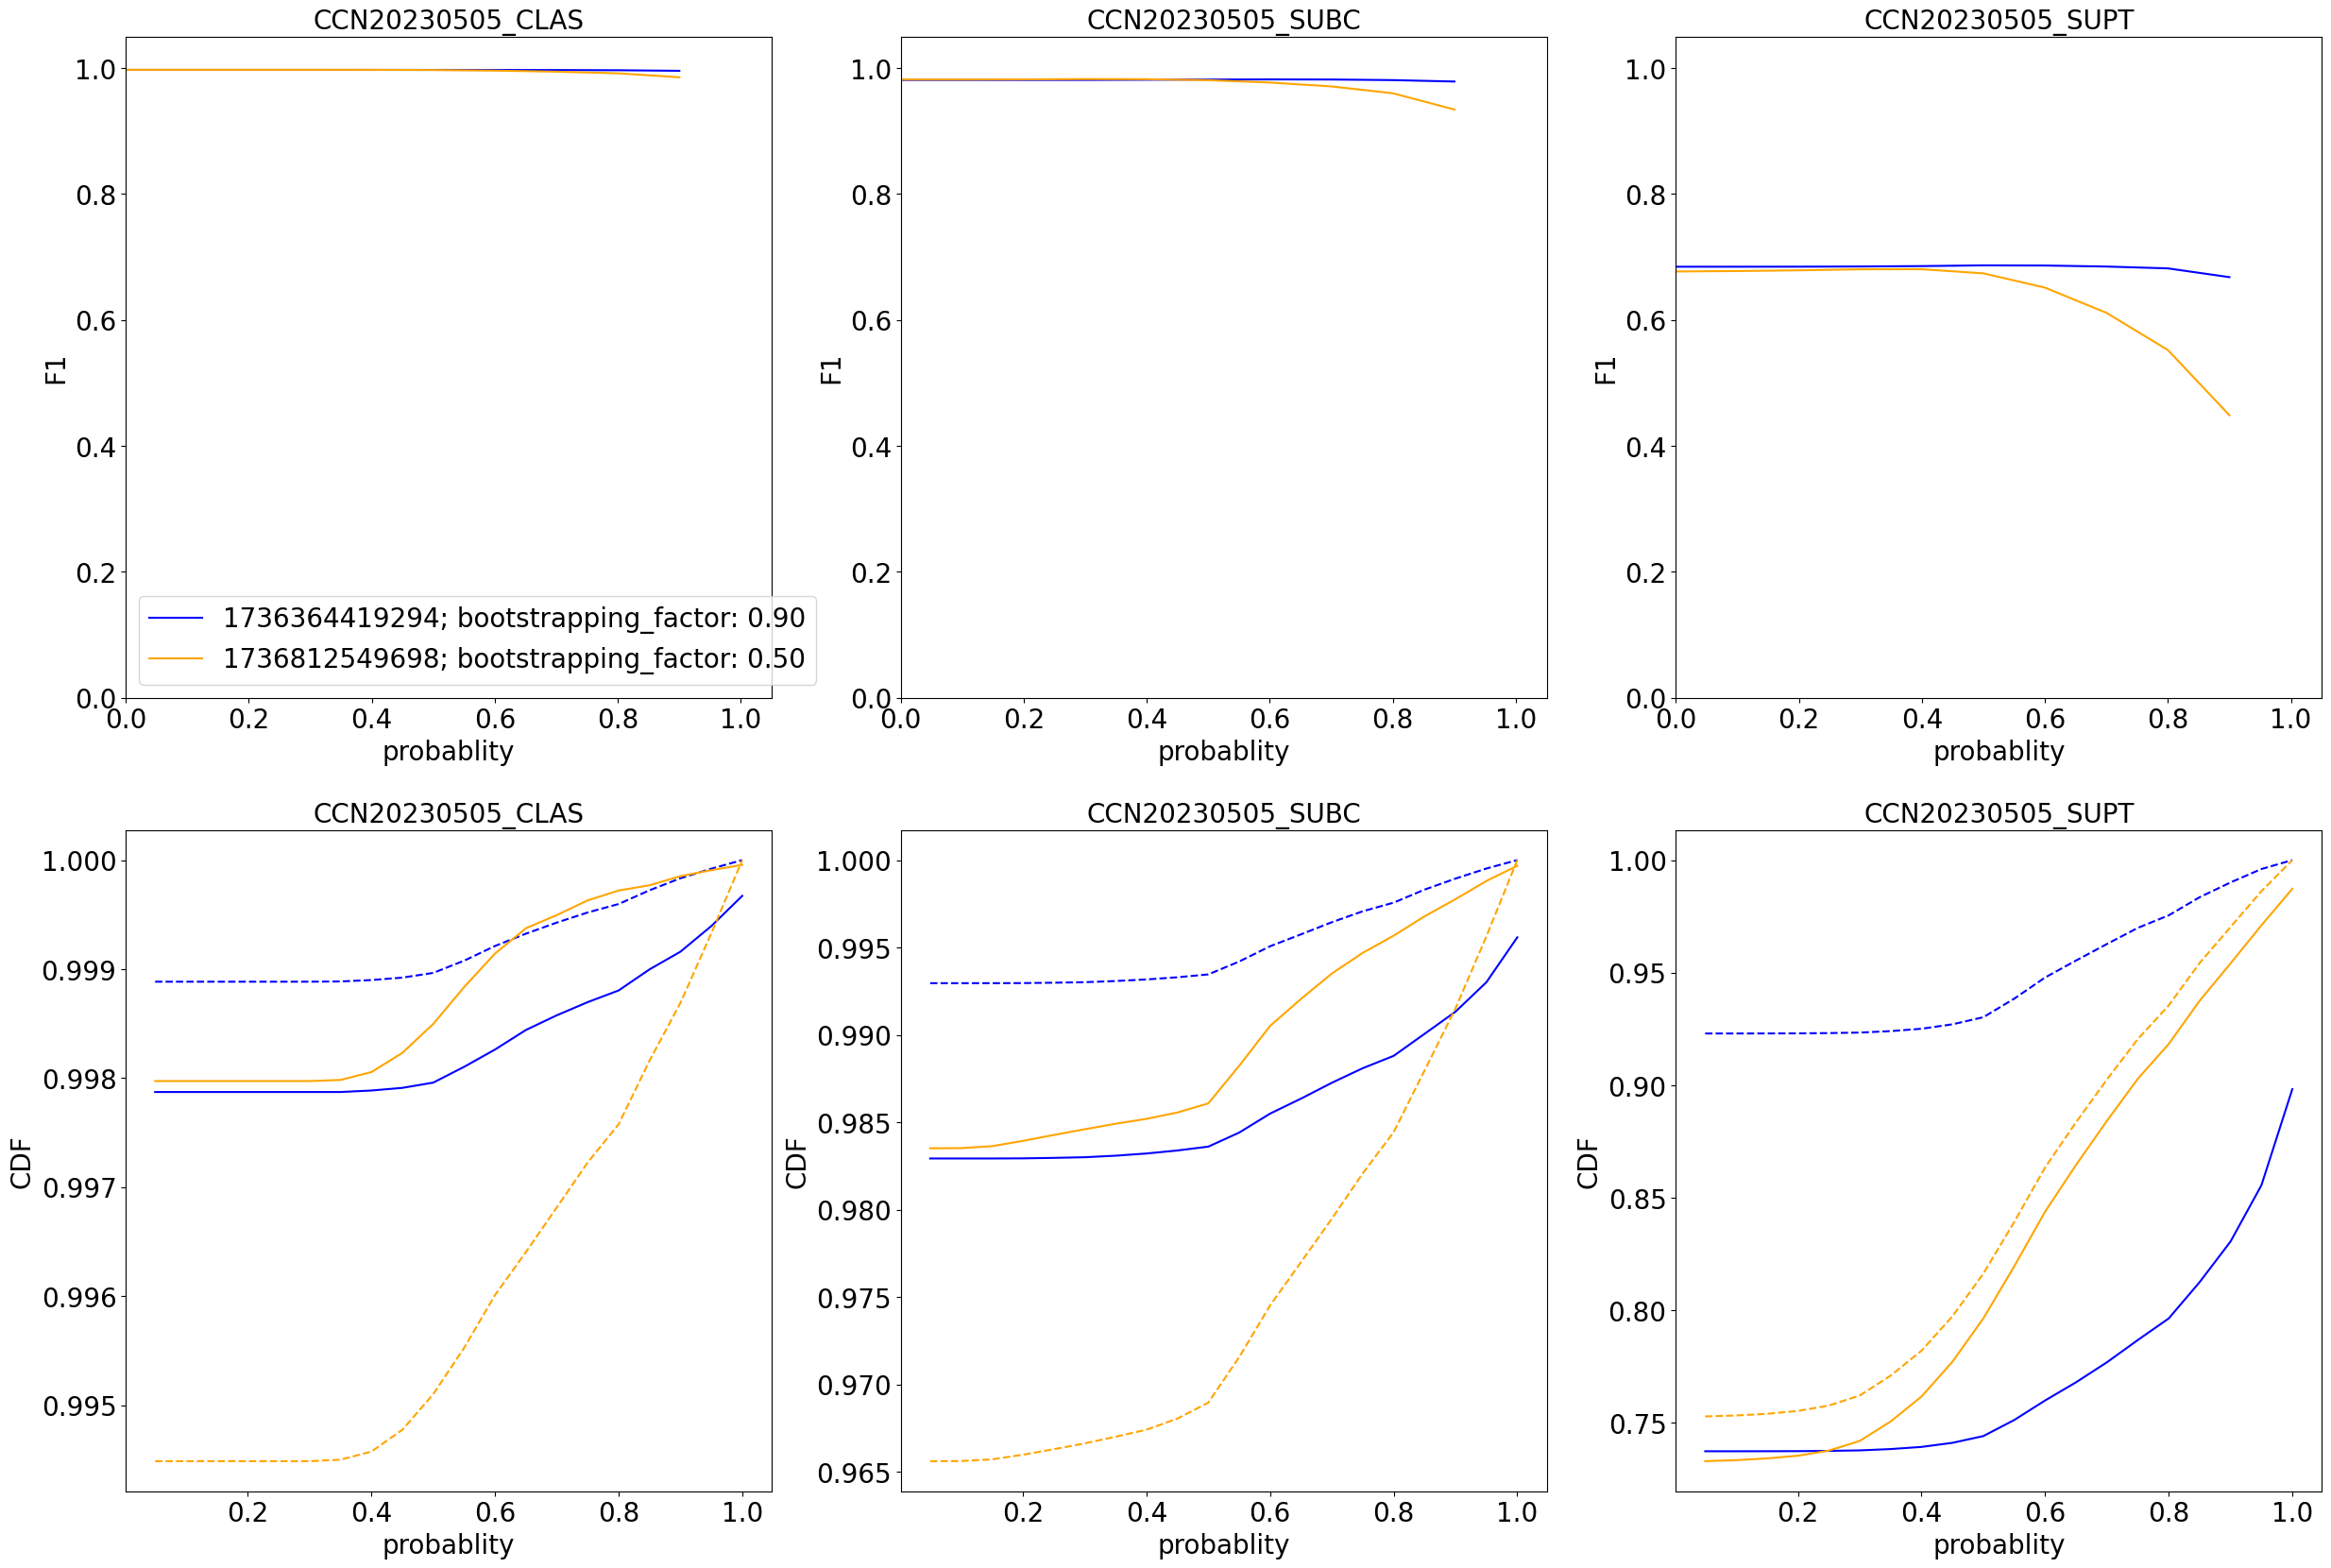

In [13]:
%%time
plot_performance(package_list=list(seaad_zip_path_to_package.values()), ground_truth=seaad_truth, fontsize=20)

# Whole Human Brain ground truth test

In [14]:
with gzip.open(baseline_dir / 'siletti_truth.json.gz', 'rb') as src:
    whb_truth = json.load(src)

In [15]:
whb_zip_path_to_package = dict()

In [16]:
result_candidates = [str(p.resolve().absolute()) for p in results_dir.rglob('siletti_smaller_test*zip')]
result_candidates.sort()

for src_path in result_candidates:
    this_package = extract_zip_package(
        src_path=src_path,
        scratch_dir=scratch_dir,
        dir_prefix='siletti_smaller_test')
    whb_zip_path_to_package[src_path] = this_package

/Users/scott.daniel/KnowledgeBase/knowledge_graph_prototypes/src/cell_type_mapper/taxonomy/utils.py:245: UserWarning: This taxonomy has no mapping from leaf_node -> rows in the cell by gene matrix
  warnings.warn("This taxonomy has no mapping from leaf_node -> rows "
/Users/scott.daniel/KnowledgeBase/knowledge_graph_prototypes/src/cell_type_mapper/evaluation/f1_scores.py:165: RuntimeWarning: invalid value encountered in divide
  f1_vals = tp/(tp+0.5*(fn+fp))


CPU times: user 11.6 s, sys: 539 ms, total: 12.1 s
Wall time: 12.1 s


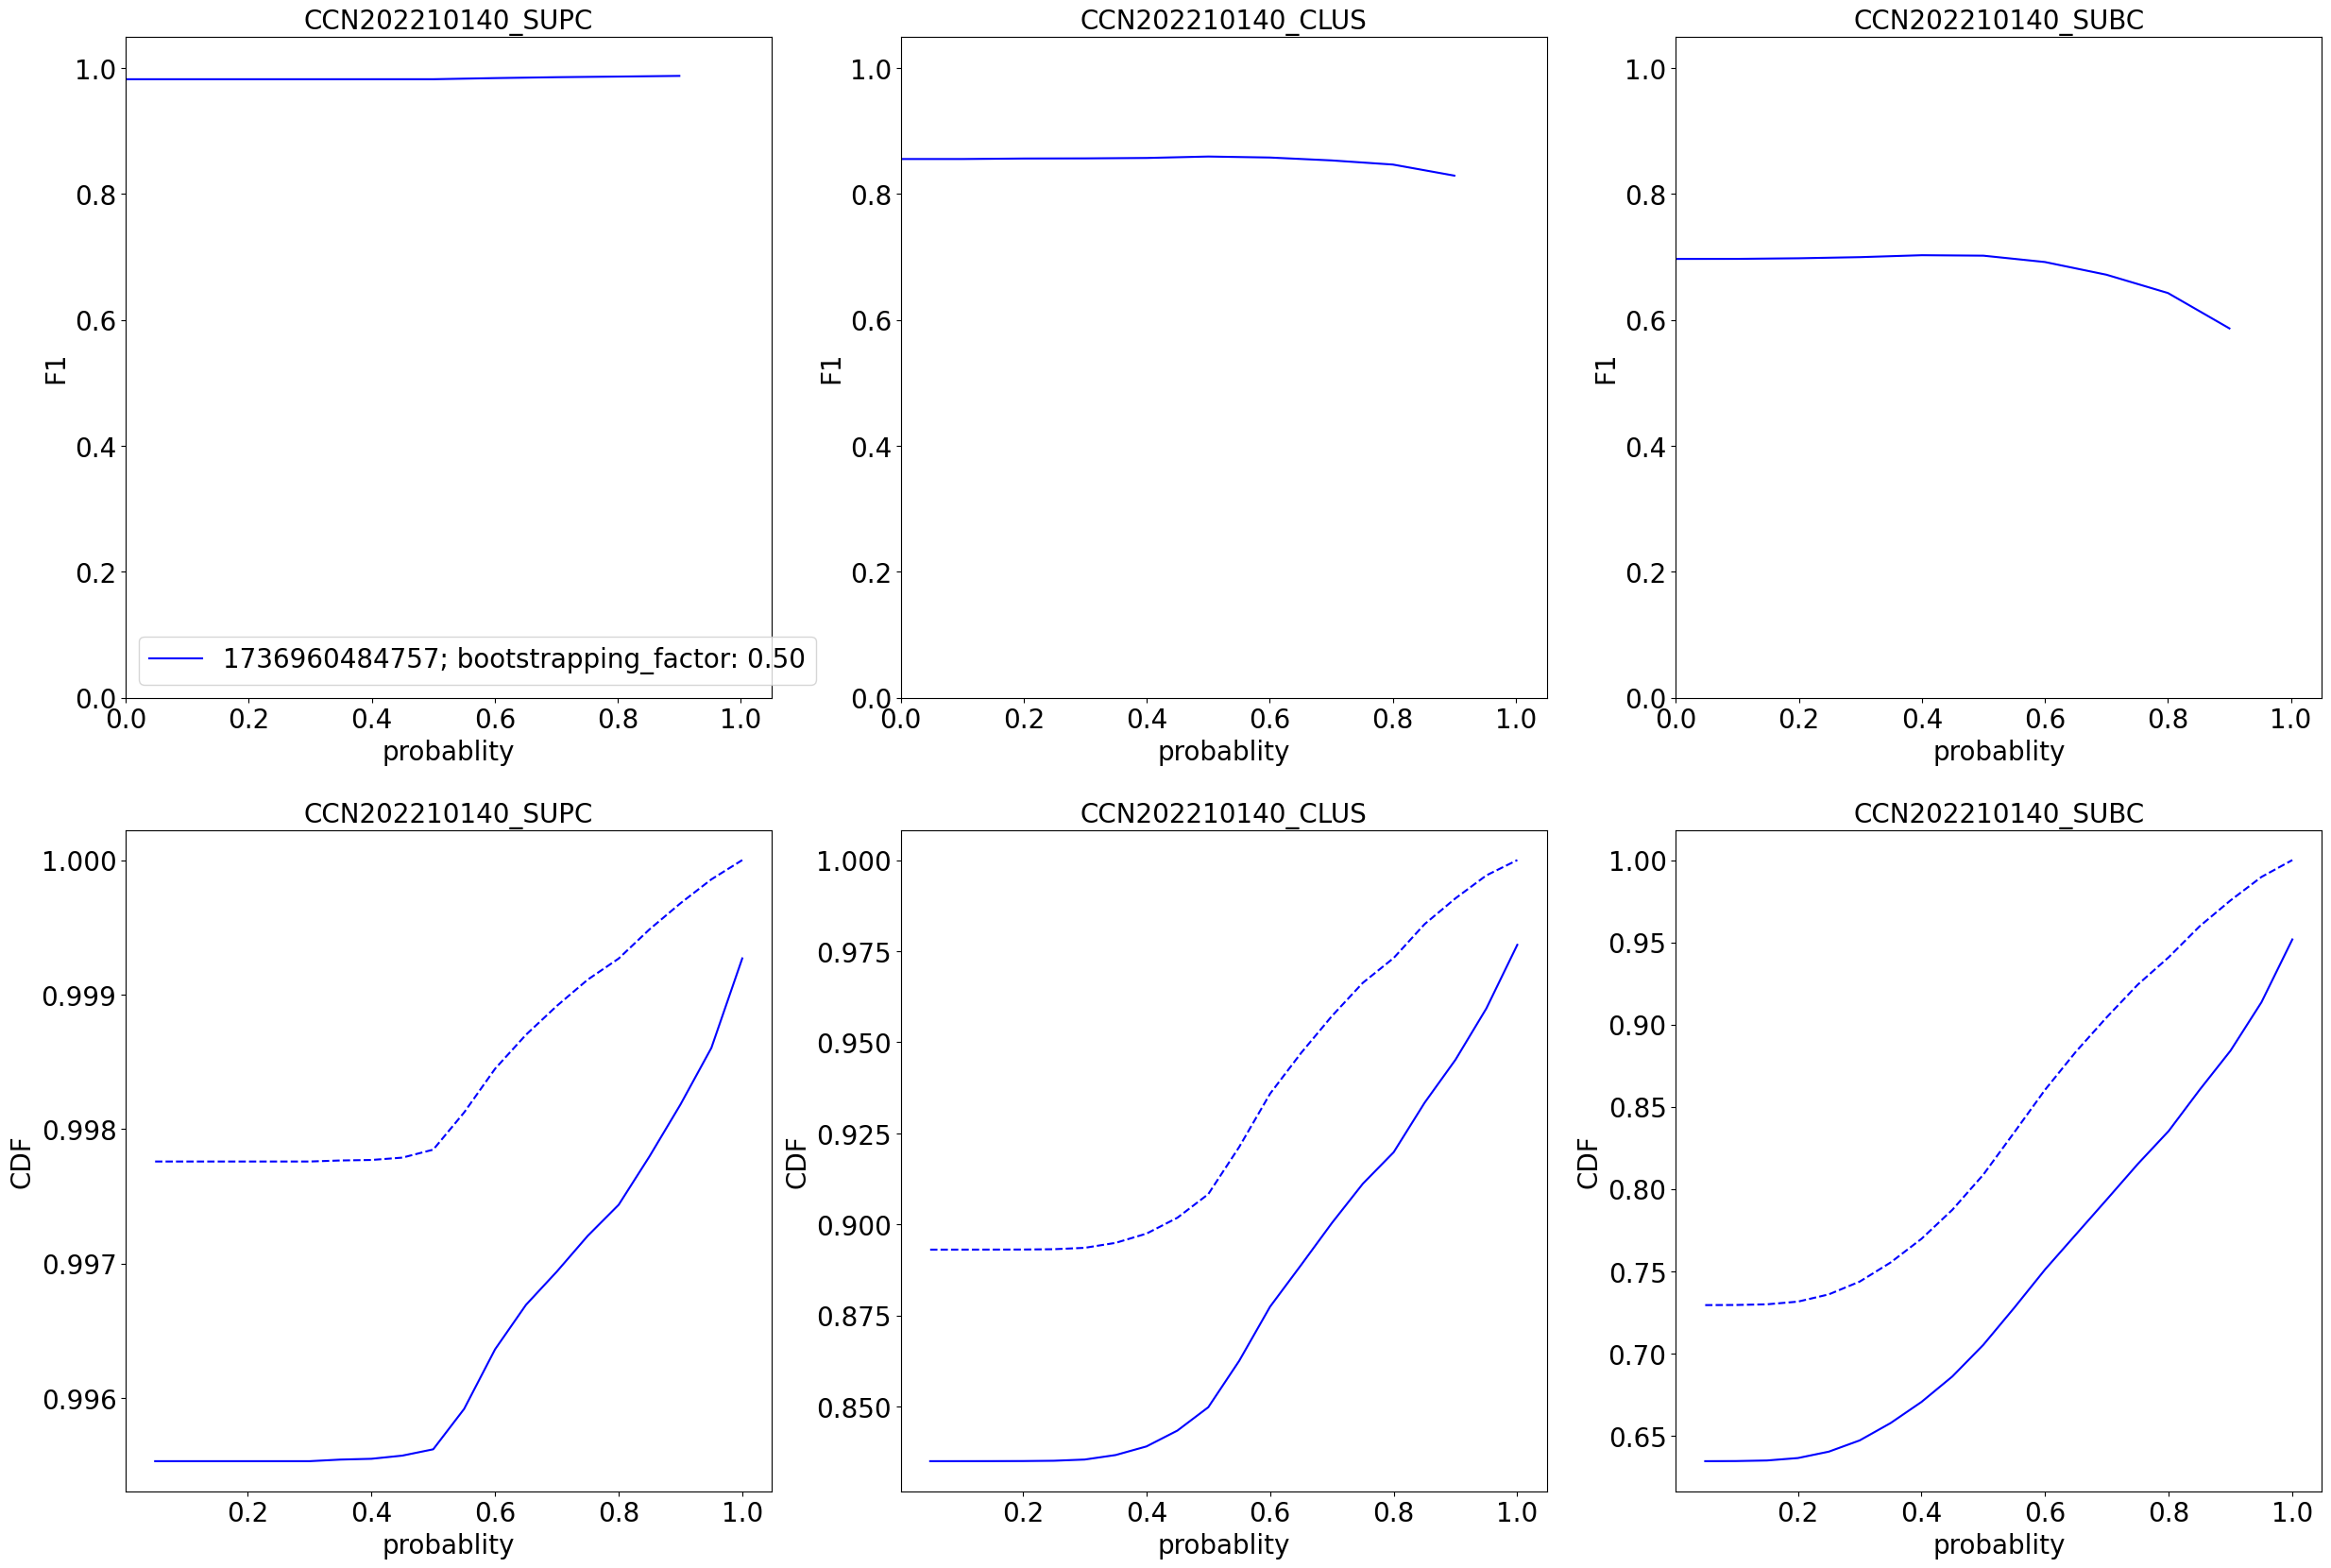

In [17]:
%%time
plot_performance(package_list=list(whb_zip_path_to_package.values()), ground_truth=whb_truth, fontsize=20)

In [18]:
def compare_mapping_labels(mapping0, mapping1):
    if len(mapping0) != len(mapping1):
        raise RuntimeError(
            f"mapping0 has {len(mapping0)} cells; "
            f"mapping1 has {len(mapping1)} cells"
        )
    for cell0, cell1 in zip(mapping0, mapping1):
        _compare_cell_labels(cell0, cell1)

def _compare_cell_labels(cell0, cell1):
    if len(cell0) != len(cell1):
        raise RuntimeError(
            f"cell0 has {len(cell0)} keys; "
            f"cell1 has {len(cell1)} keys"
        )
    is_okay = True
    violation = ''
    for level in cell0:
        if level == 'cell_id':
            continue
        if not cell0[level]['assignment'] == cell1[level]['assignment']:
            is_okay=False
            violation = (
                f'{level} assignment {cell0[level]["assignment"]} != '
                f'{cell0[level]["assignment"]}'
            )
            break
        if 'runner_up_assignment' in cell0[level]:
            r0 = np.array(cell0[level]['runner_up_assignment'])
            r1 = np.array(cell1[level]['runner_up_assignment'])
            if not np.array_equal(r0, r1):
                is_okay = False
                violation = (
                    f'{level} runners up {cell0[level]["runner_up_assignment"]} != '
                    f'{cell1[level]["runner_up_assignment"]}'
                )

    if not is_okay:
        msg = json.dumps(cell0, indent=2)
        msg += "\n=======\n"
        msg += json.dumps(cell1, indent=2)
        msg += f'\n{violation}'
        raise RuntimeError(msg)

In [54]:
def equivalence_test(package_lookup):
    baseline_result = None
    baseline_k = None
    for k in package_lookup:
        if 'baseline' in k:
            baseline_k = k
            baseline_result = package_lookup[k]

    print(f'treating {baseline_k} as baseline mapping\n=======')
    baseline_mapping = json.load(open(baseline_result['json'], 'rb'))
    for cell in baseline_mapping['results']:
        cell.pop('cell_id')

    for k in package_lookup:
        if k == baseline_k:
            continue
        print(f'testing equivalence of {k}')
        test_mapping = json.load(open(package_lookup[k]['json'], 'rb'))
        for cell in test_mapping['results']:
            cell.pop('cell_id')
        assert test_mapping['results'] == baseline_mapping['results']

# Mouse cartoon test

In [35]:
mouse_cartoon_lookup = {
    p.name: extract_zip_package(src_path=p, scratch_dir=scratch_dir, dir_prefix='cartoon_mouse_')
    for p in results_dir.rglob('cartoon_mouse_*')
}

In [36]:
len(mouse_cartoon_lookup)

3

In [45]:
equivalence_test(mouse_cartoon_lookup)

treating cartoon_mouse_baseline_10xWholeMouseBrain(CCN20230722)_HierarchicalMapping_UTC_1736788605950.zip as baseline mapping
testing cartoon_mouse_degenerate_labelscsv_10xWholeMouseBrain(CCN20230722)_HierarchicalMapping_UTC_1736790047574.zip
testing cartoon_mouse_csvcsv_10xWholeMouseBrain(CCN20230722)_HierarchicalMapping_UTC_1736788907825.zip


In [46]:
degenerate_package = None
for k in mouse_cartoon_lookup:
    if 'degenerate' in k:
        degenerate_package = mouse_cartoon_lookup[k]

In [47]:
with open(degenerate_package['validation_log'], 'r') as src:
    for line in src.readlines():
        print(line)

8.91685e-04 seconds == WARNING: Input data is in CSV format; converting to h5ad file at cartoon_mouse_degenerate_labels-2025-01-13-17-41-23.h5ad

1.50372e+01 seconds == WARNING: The index values in the obs dataframe of your file are not unique. We are modifying them to be unique. 

1.55846e+01 seconds == Mapping genes to mouse genes

1.55852e+01 seconds == WARNING: Not all of your gene identifiers were EnsemblID; 249 were mapped to EnsemblID; 1 were already EnsemblID

1.67037e+01 seconds == VALIDATION: copied cartoon_mouse_degenerate_labels-2025-01-13-17-41-23.h5ad to cartoon_mouse_degenerate_labels_20250113174123.validated_by_MMC.h5ad

1.67037e+01 seconds == VALIDATION: modifying var dataframe of cartoon_mouse_degenerate_labels-2025-01-13-17-41-23.h5ad to include proper gene identifiers

1.88156e+01 seconds == DONE VALIDATING cartoon_mouse_degenerate_labels-2025-01-13-17-41-23.h5ad; reformatted file written to cartoon_mouse_degenerate_labels_20250113174123.validated_by_MMC.h5ad



1.9

# Small mouse cartoon test

In [48]:
small_mouse_cartoon_lookup = {
    p.name: extract_zip_package(src_path=p, scratch_dir=scratch_dir, dir_prefix='small_cartoon_mouse_')
    for p in results_dir.rglob('small_cartoon_mouse_*')
}

In [49]:
len(small_mouse_cartoon_lookup)

10

In [55]:
equivalence_test(small_mouse_cartoon_lookup)

treating small_cartoon_mouse_baseline_10xWholeMouseBrain(CCN20230722)_HierarchicalMapping_UTC_1736790095491.zip as baseline mapping
testing equivalence of small_cartoon_mouse_gzippedcsvgz_10xWholeMouseBrain(CCN20230722)_HierarchicalMapping_UTC_1736790232293.zip
testing equivalence of small_cartoon_mouse_transposed_10xWholeMouseBrain(CCN20230722)_HierarchicalMapping_UTC_1736790295892.zip
testing equivalence of small_cartoon_mouse_csc_10xWholeMouseBrain(CCN20230722)_HierarchicalMapping_UTC_1736790172432.zip
testing equivalence of small_cartoon_mouse_no_encoding_10xWholeMouseBrain(CCN20230722)_HierarchicalMapping_UTC_1736793042353.zip
testing equivalence of small_cartoon_mouse_numericalcsv_10xWholeMouseBrain(CCN20230722)_HierarchicalMapping_UTC_1736790278511.zip
testing equivalence of small_cartoon_mouse_big_numericalcsv_10xWholeMouseBrain(CCN20230722)_HierarchicalMapping_UTC_1736790144392.zip
testing equivalence of small_cartoon_mouse_csvcsv_10xWholeMouseBrain(CCN20230722)_HierarchicalMa

In [103]:
def check_for_warning(
        file_name_prefix,
        warning_msg):

    path_list = [n for n in results_dir.iterdir() if n.name.startswith(file_name_prefix)]
    for has_warning_path in path_list:
        has_warning_package = extract_zip_package(
            src_path=has_warning_path,
            scratch_dir=scratch_dir,
            dir_prefix='has_warning')

        _check_for_warning(
            has_warning_package,
            warning_msg=warning_msg)

def _check_for_warning(package, warning_msg):
    mapping = json.load(open(package['json'], 'rb'))
    with open(package['validation_log'], 'r') as src:
        validation_log = src.readlines()

    assert len(mapping['results']) > 0

    found_in_json = False
    found_in_log = False
    for line in mapping['log']:
        if warning_msg in line:
            found_in_json = True
            break

    for line in validation_log:
        if warning_msg in line:
            found_in_log = True
            break

    json_name = pathlib.Path(package["json"]).name
    
    error_msg = ''
    if not found_in_json:
        error_msg += f'failed to find "{warning_msg}" in JSON log\n'
    if not found_in_log:
        error_msg += f'failed to find "{warning_msg}" in validation_log.txt'
    if len(error_msg) > 0:
        raise RuntimeError(f'{json_name}\n' + error_msg)
    print(f'PASSED: {json_name}')

In [101]:
def check_for_error(file_name_prefix, error_msg):
    path_list = [n for n in results_dir.iterdir() if n.name.startswith(file_name_prefix)]
    for corrupted_path in path_list:
        corrupted_package = extract_zip_package(
            src_path=corrupted_path,
            scratch_dir=scratch_dir,
            dir_prefix='failed_'
        )
        print(f'testing {corrupted_path.name}')
        _check_for_error(
            corrupted_package,
            error_msg=error_msg
        )


def _check_for_error(package, error_msg):
    full_error_msg = ''
    if 'json' in package:
        mapping = json.load(open(package['json'], 'rb'))
        if 'results' in mapping:
            assert len(mapping['results'])== 0
        found_in_json = False
        for line in mapping['log']:
            if error_msg in line:
                found_in_json = True
                break
        if not found_in_json:
            full_error_msg += f'failed to find "{error_msg}" in JSON log\n'
    
    with open(package['validation_log'], 'r') as src:
        validation_log = src.readlines()

    found_in_log = False

    for line in validation_log:
        if error_msg in line:
            found_in_log = True
            break

    if not found_in_log:
        full_error_msg += f'failed to find "{error_msg}" in validation_log.txt'
    if len(full_error_msg) > 0:
        raise RuntimeError(full_error_msg)
    print('PASSED')

# Poorly formatted data tests

In [107]:
check_for_warning(
    file_name_prefix='mouse_warning_has_nan',
    warning_msg="WARNING: There were NaN gene expression values in cells"
)

PASSED: mouse_warning_has_nan_10xWholeMouseBrain(CCN20230722)_HierarchicalMapping_UTC_1736958154782.json


In [108]:
check_for_error(
    file_name_prefix='failure_corrupted',
    error_msg='This h5ad file is corrupted such that it could not even be opened with h5py'
)

testing failure_corrupted_10xWholeMouseBrain(CCN20230722)_HierarchicalMapping_UTC_1736957926671.zip
PASSED


In [109]:
check_for_error(
    file_name_prefix='failure_repeated_mouse_genes',
    error_msg='gene names must be unique'
)

testing failure_repeated_mouse_genes_10xWholeMouseBrain(CCN20230722)_HierarchicalMapping_UTC_1736958030483.zip
PASSED


In [110]:
check_for_error(
    file_name_prefix='failure_zero_mouse_markers',
    error_msg='no valid marker genes could be found at any level in the taxonomy'
)

testing failure_zero_mouse_markers_10xWholeMouseBrain(CCN20230722)_HierarchicalMapping_UTC_1736958085001.zip
PASSED


In [111]:
check_for_error(
    file_name_prefix='failure_improper_csv',
    error_msg='An error occurred when reading your CSV with anndata'
)

testing failure_improper_csvtxtgz_10xWholeMouseBrain(CCN20230722)_HierarchicalMapping_UTC_1736957852160.zip


RuntimeError: failed to find "An error occurred when reading your CSV with anndata" in validation_log.txt